## ACM SIGCHI Summer School on Computational Interaction
#### Inference, optimization and modeling for the engineering of interactive systems
#### 12-17 June 2017
##### Lucerne, Switzerland, ETH Zurich
-----

# Inferring typing behaviour: II

In [1]:
import numpy as np
import sklearn.datasets, sklearn.linear_model, sklearn.neighbors
import sklearn.manifold, sklearn.cluster
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os, time
import pymc as mc
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (18.0, 10.0)


## MCMC in practice: sampling issues
<a id="sampling"> </a>

The **great thing** about MCMC approaches is that you can basically write down your model and then run inference directly. There is no need to derive complex approximations, or to restrict ourselves to limited models for which we can compute answers analyitically.

MCMC allows us to use distributions *we can't even sample from directly*. First we couldn't calculate the evidence P(B), so we integrated; but we couldn't solve the integral, so we sampled; but then we couldn't sample from the distribution so we used MCMC. It's a very general approach!

The **bad thing** about MCMC approaches is that, even though it will do the "right thing" *asymptotically*, the choice of sampling strategy has a very large influence for the kind of sample runs that are practical to execute.

Bayesian inference should depend only on the priors and the evidence observed; but MCMC approaches also depend on the sampling strategy used to approximate the posterior. 



### Rejection sampling

The simplest way to perform Monte Carlo sampling for a distribution we can't sample directly is to do **rejection sampling**. We have a distribution we want to sample given by a pdf $p(x)$, and instead sample from an easy distribution $q(x)$, (usually uniform, i.e. a box) where $q(x)>p(x) \forall x$. Then, we draw a new sample $x_q$ from $q(x)$ (horizontal sample) and then sample uniformly from $x_s = [0,x_q]$ (vertical sample) and see if $x_s<f(x_q)$. If we so we keep it as a draw from the distribution, otherwise we reject it.

This is easy to implement, but works very poorly in *high dimensions* because the rejection rate increases exponentially with increasing dimension.

Fraction under the curve: 0.27


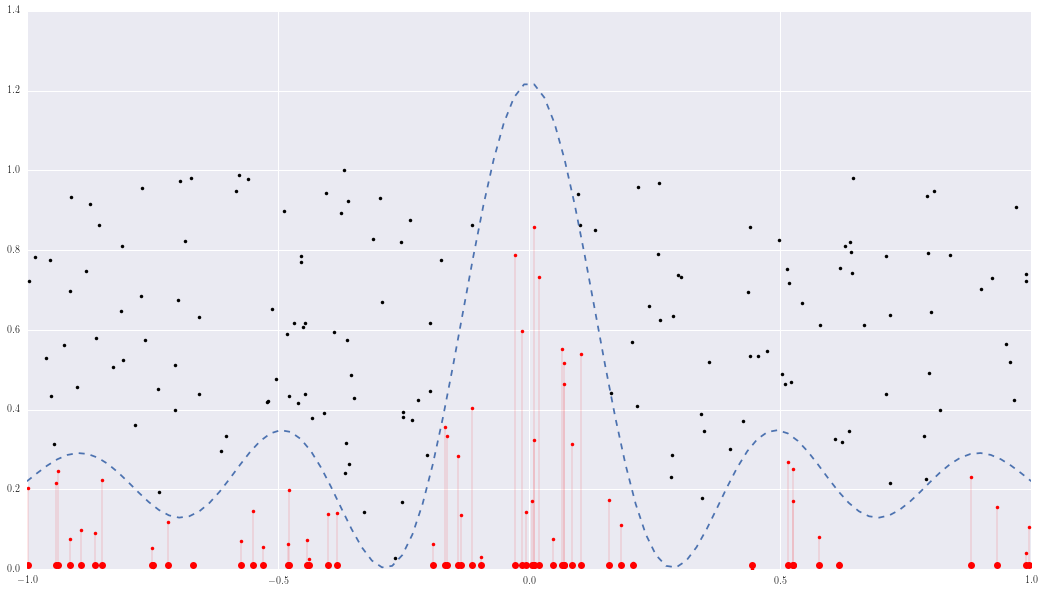

In [3]:
def rejection_sample(p,interval_x, interval_y, n):
    xs = np.random.uniform(interval_x[0], interval_x[1],(n,))
    ys = np.random.uniform(interval_y[0], interval_y[1],(n,))
    kept  = p(xs)>ys
    return kept, np.logical_not(kept), xs, ys

def odd_pdf(x):
    return np.sin(x*5*np.pi) / ((x*5*np.pi)) + 0.22

kept, rejected, xs, ys = rejection_sample(odd_pdf, [-1,1], [0,1], 200)
plt.plot(xs[kept], ys[kept], 'r.')

plt.plot(xs[kept], np.zeros_like(xs[kept])+0.01, 'ro')
for x,y in zip(xs[kept], ys[kept]):
    plt.plot([x,x], [0.01,y], 'r', alpha=0.1)

plt.plot(xs[rejected], ys[rejected], 'k.')

xf = np.linspace(-1,1,100)
plt.plot(xf,odd_pdf(xf), '--')

print "Fraction under the curve: %.2f" % (np.sum(kept) / float(len(xs)))
        

### Metropolis-Hastings
Metropolis-Hastings (or just plain Metropolis) takes a different approach, and is able to work in high-dimensional spaces. Metropolis also uses an auxiliary distribution $q(x)$, but it uses this to **wander around** in the distribution space, accepting jumps to new positions based on both $q(x)$ and $p(x)$.  This random walk (a **Markov chain**, because we make a random jump conditioned only on where we currently are) is a the "Markov Chain" bit of "Markov Chain Monte Carlo".

We just take our current position $x$, and propose a new position $x^\prime = x + x_q$, where $x_q$ is a random sample drawn from $q(x)$. This makes local steps in the space of the probability density. If $q(x)$ has a simple, symmetric form (e.g. is Gaussian), there is a very simple formula to decide whether to accept or reject a step from $p(x)$ to a new candidate position $p(x^\prime)$:
$$
p(\text{accept}) = \begin{cases} p(x^\prime)/p(x), & p(x)>=p(x^\prime) \\  1, & p(x)<p(x^\prime) \end{cases} $$

The asymmetric case is only slightly more involved, but it is very unusual to need to use it.

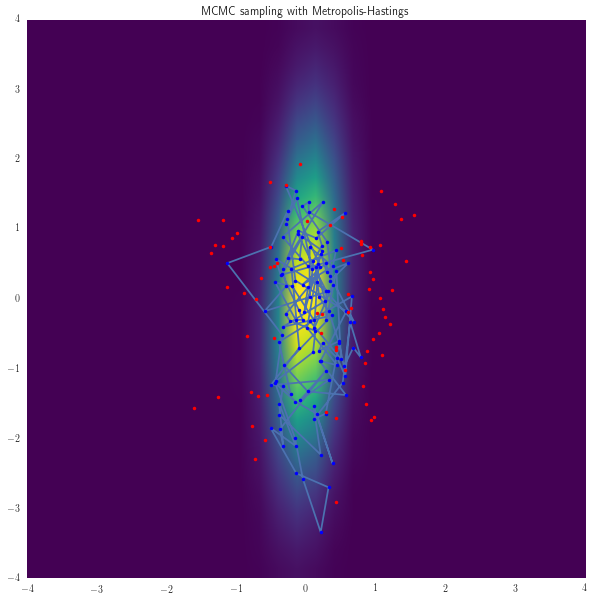

In [7]:
def metropolis(p,q,x_init,n):
    x = x_init
    
    samples = []
    rejected = [] # we only keep the rejected samples to plot them later
    for i in range(n):
        # find a new candidate spot to jump to
        x_prime = x + q()
        # if it's better, go right away
        if p(x_prime)>p(x):
            x = x_prime
            samples.append(x_prime)            
        else:
            # if not, go with probability proportional to the
            # ratio between the new point and the current one
            pa = p(x_prime)/p(x)
            if np.random.uniform(0,1)<pa:
                x = x_prime
                samples.append(x_prime)
            else:
                rejected.append(x_prime)
                
    return np.array(samples), np.array(rejected)


A = np.array([[0.15, 0.9], [-0.1, 2.5]])
p = lambda x:scipy.stats.multivariate_normal(mean=[0,0], cov=A).pdf(x)
q = lambda: np.random.normal(0,0.5,(2,))
accept, reject = metropolis(p,q,[0.1, 0.3], 200)
plt.figure(figsize=(10,10))
plt.plot(accept[:,0], accept[:,1])
plt.plot(accept[:,0], accept[:,1], 'b.')
plt.plot(reject[:,0], reject[:,1], 'r.')
x,y = np.meshgrid(np.linspace(-5,5,30), np.linspace(-4,4,30))
plt.imshow(p(np.dstack([x,y])), extent=[-4,4,-4,4], cmap='viridis')
plt.grid("off")
plt.title("MCMC sampling with Metropolis-Hastings")        


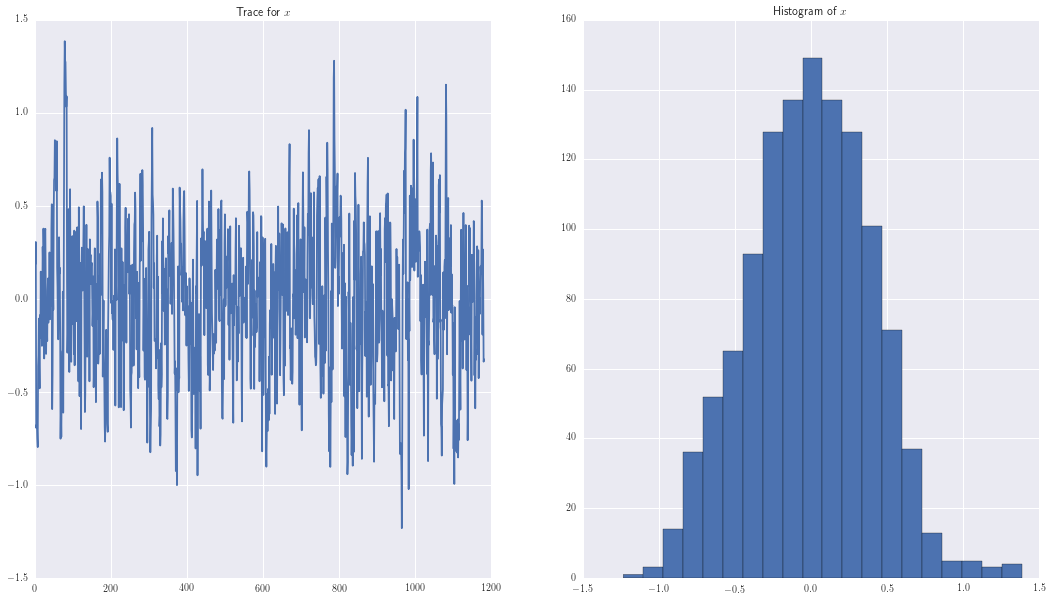

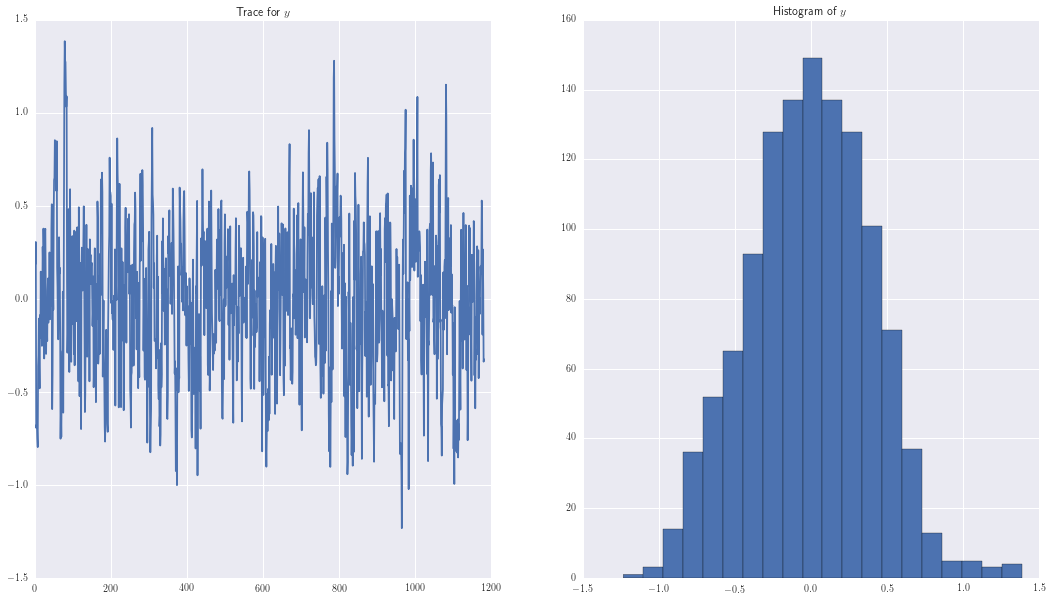

In [8]:
# run the chain for longer, and plot the trace and the histogram of the variable
accept, reject = metropolis(p,q,[0.1, 0.3], 2000)
plt.subplot(1,2,1)
plt.plot(accept[:,0])
plt.title("Trace for $x$")
plt.subplot(1,2,2)
plt.hist(accept[:,0], bins=20)
plt.title("Histogram of $x$")

plt.figure()

plt.plot(accept[:,1])
plt.subplot(1,2,1)
plt.title("Trace for $y$")
plt.plot(accept[:,0])
plt.subplot(1,2,2)
plt.title("Histogram of $y$")
plt.hist(accept[:,0], bins=20);


### Others
There are many other MCMC samplers, such as:
* **Gibbs** samplers, which are very efficient when we can sample from the conditional distribution (i.e. from one dimension of a distribution at a time), but not from the joint directly.
* **Hamiltonian** samplers, which extend Metropolis-like steps with "virtual physics" which pushes the samples in sensible directions (i.e. not down the gradient of the function!)
* **Slice** samplers, which are very clever and efficient, but only work for 1-dimensional (univariate) distributions.



## Burn-in and thinning
MCMC tries to draw **independent, unbiased** samples from the posterior, but the sampling process (like Metropolis), is not inherently unbiased. For example, successive samples in a random walk are correlated and obviously not independent. 

And although the Markov Chain approach (under fairly relaxed assumptions) will asympotically sample from all of the posterior, if the random walk starts off very far from the bulk of the distribution, it will "wander in the wilderness" for some time before reaching significant probability density. This means early samples from the distribution might be unreasonably dense in very low probability regions in the posterior. How "good" the Markov chain is at sampling from the posterior is called **mixing**; some MCMC setups may mix very badly until they get warmed up.

To mitigate these two common issues, there are a couple of standard tricks: 
* **Burn-in**, which ignores the first $n$ samples from an MCMC draw, to make sure the chain is mixing well. Typically, several thousand samples might be ignored.
* **Thinnning**, which takes one sample from every $k$ consecutive samples from the chain, to reduce correlation. Values of raound 5-50 are common.

Tuning these is a matter of art!

## Rejection rate
The **rejection rate** of a sampler is a common heuristic measure of how well the chain is mixing. A chain that always accepts a jump is probably just wandering around in a tiny, high-density area of the pace. A chain that almost never jumps is probably trying to sample too diversely, into very improbable regions of the space. Some **adaptive** algorithms, like adaptive Metropolis, optimise the rejection rate. A common technique is to try to hold the acceptance rate at 50%, adjusting the proposal distribution width (for Metropolis sampling) to be larger if the rate trends above this, and smaller if the rate drops too low.

This doesn't guarantee good mixing behaviour (why should 50% rejection be a good choice?), but it often does a reasonable job, especially if you have no prior information about the proposal distribution to use.


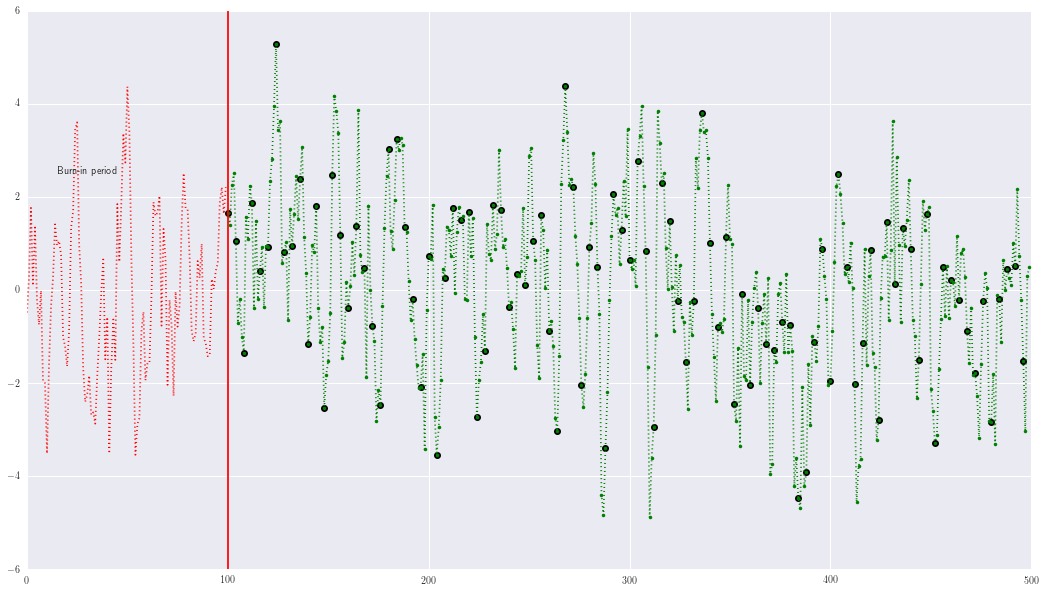

In [9]:
## Burn-in and thinning plot
y = np.random.normal(0,1,(500,))

# introduce correlations
y = scipy.signal.lfilter([1,1, 1, 1], [1], y)
x = np.arange(len(y))

burn = 100
thin = 4
plt.plot(x[0:burn], y[0:burn], 'r:')
plt.plot(x[burn::thin], y[burn::thin], 'ko')
plt.plot(x[burn:], y[burn:], 'g:')
plt.plot(x[burn:], y[burn:], 'g.')


plt.axvline(burn, c='r')
plt.text(15,2.5,"Burn-in period")


If you're interested in learning more about MCMC, David Mackay's [book chapter](http://www.inference.phy.cam.ac.uk/mackay/itprnn/ps/356.384.pdf) is a good reference.

# Language modelling
<a id="bigram"> </a>

In the keystroke event datasets, we are predicting a sequence of discrete symbols, which has very regular and repetitive structure. Capturing the regularities in symbol sequences is **language modelling**. In traditional text entry, a language model captures natural language to improve typing performance. We'll look at using a language model to predict keystroke data for the coding and navigating tasks that we have captured, using standard language modelling approaches.


## Bigram model
We can build a very simple probabilistic language model using *n-grams*, where we predict the next occurence of a symbol given some previous sequence of $n$ symbols. **This is a Markov assumption; that the current state depends only on the previous state** (a fixed sequence of $n$ previous symbols can be bundled into a single previous state for the sake of argument).

A very basic model is a character-level bigram model, where we model the probability of a character $c_n$ given a previously seen character $c_{n-1}$, $p(c_n|c_{n-1})$. 

The probability distribution can be inferred from data simply by counting the occurence of each pair $(c_{n-1}, c_{n})$ and storing the result in a matrix which has dimensions $d \times d$ where $d$ is the number of distinct characters. If we then normalise by dividing each row by the total count of that character, we approximate the probability distribution of the language. 



In [16]:
def numerify(string):
    # remove all but letters and space (note that this is not a very efficient way to do this process)
    # and then convert to 0=space, 1-27 = a-z
    filtered_string = [max(1+ord(c.lower()) - ord('a'), 0) for c in string if c.isalpha() or c.isspace()]
    return filtered_string

def learn_bigram(string):
    # return a matrix with the bigram counts from string, including only letters and whitespace
    coded = numerify(string)
    joint = np.zeros((27,27))
    # iterate over sequential pairs
    for prev, this in zip(coded[:-1], coded[1:]):
        joint[prev, this] += 1
    # note that we add on an epsilon to avoid dividing by zero!
    bigram = joint.T / (np.sum(joint, axis=0)+1e-6)
    return bigram.T, joint.T
        
    

In [17]:
with open("data/macbeth.txt") as f:
    macbeth_bigram, macbeth_joint = learn_bigram(f.read())

with open("data/metamorphosis.txt") as f:
    metamorphosis_bigram, metamorphosis_joint = learn_bigram(f.read())
    


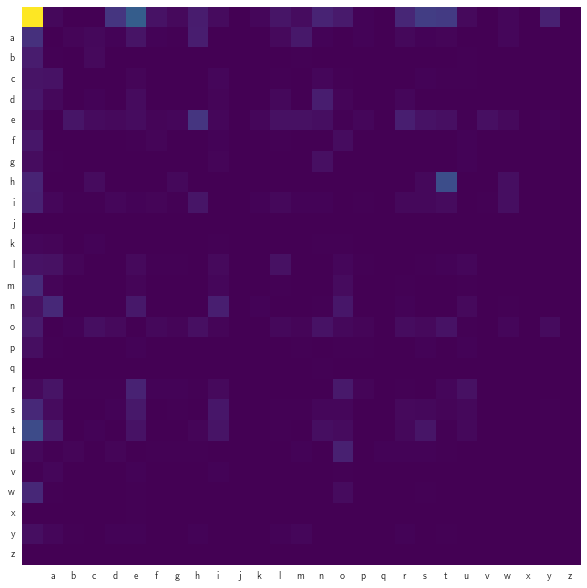

In [12]:
# The joint distribution
plt.imshow(macbeth_joint, interpolation='nearest', cmap="viridis")
plt.xticks(range(27), ' abcdefghijklmnopqrstuvwxyz')
plt.yticks(range(27), ' abcdefghijklmnopqrstuvwxyz')
plt.grid('off')

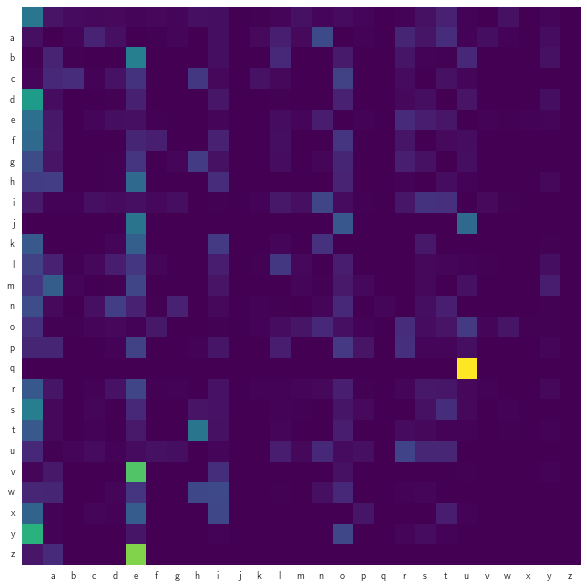

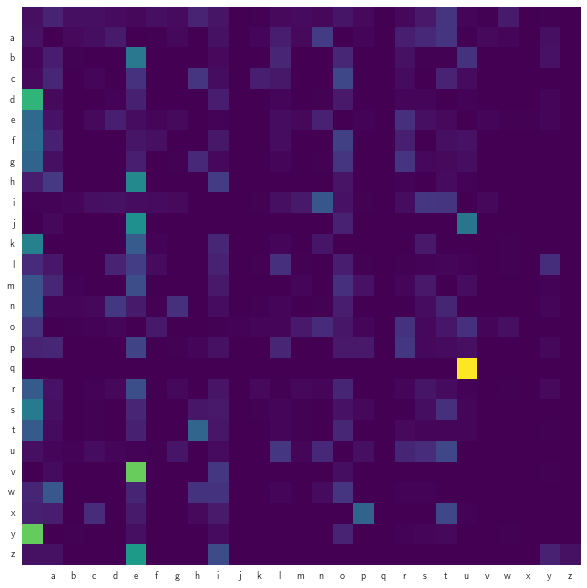

In [13]:
# The conditional distributions
plt.imshow(macbeth_bigram, interpolation='nearest', cmap="viridis")
plt.xticks(range(27), ' abcdefghijklmnopqrstuvwxyz')
plt.yticks(range(27), ' abcdefghijklmnopqrstuvwxyz')
plt.grid('off')

plt.figure()
plt.imshow(metamorphosis_bigram, interpolation='nearest', cmap="viridis")
plt.xticks(range(27), ' abcdefghijklmnopqrstuvwxyz')
plt.yticks(range(27), ' abcdefghijklmnopqrstuvwxyz')
plt.grid('off')

#### Log probabilities

The probability of multiple **independent** random variables taking on a set of values can be computed from the product:
$$p(x,y,z) = p(x)p(y)p(z)$$
and in general
$$p(x_1, \dots, x_n) = \prod_{i=1}^{n} x_i$$

We often have to have to compute such products, but to multiply lots of values $<1$ leads to numerical issues. Instead, we often prefer to manipluate *log probabilities*, which can be summed instead of multiplied:
$$\log p(x_1, \dots, x_n) = \sum_{i=1}^{n} \log p(x_i)$$

This is simply a numerical conveience.

In [14]:
 def log_likelihood_bigram(string, bigram):
    symbols = numerify(string)
    llik = 0
    # we sum the log probabilities to avoid numerical underflow
    for prev, this in zip(symbols[:-1], symbols[1:]):
        llik += np.log(bigram[prev, this]+1e-8) 
    return llik

In [15]:

def compare_logp(fname):
    print fname

    with open(fname) as f:
        text = f.read()
        mb_llik = log_likelihood_bigram(text, macbeth_bigram) / len(text)
        mm_llik = log_likelihood_bigram(text, metamorphosis_bigram) / len(text)
        diff = mb_llik - mm_llik
        print "\tlogp Macbeth: % 10.2f\t logp Metamorphosis:% 10.2f\t Difference logp:% 10.2f" % (mb_llik, mm_llik, diff)
        if diff>0:
            print "\tModel favours: Macbeth"            
        else:
            print "\tModel favours: Metamorphosis"

    print
    
compare_logp("data/macbeth.txt")
compare_logp("data/metamorphosis.txt")
compare_logp("data/romeo_juliet.txt")
compare_logp("data/the_trial.txt")



data/macbeth.txt
	logp Macbeth:      -2.14	 logp Metamorphosis:     -2.44	 Difference logp:      0.31
	Model favours: Macbeth

data/metamorphosis.txt
	logp Macbeth:      -2.37	 logp Metamorphosis:     -2.21	 Difference logp:     -0.16
	Model favours: Metamorphosis

data/romeo_juliet.txt
	logp Macbeth:      -2.21	 logp Metamorphosis:     -2.38	 Difference logp:      0.17
	Model favours: Macbeth

data/the_trial.txt
	logp Macbeth:      -2.34	 logp Metamorphosis:     -2.22	 Difference logp:     -0.11
	Model favours: Metamorphosis



## Imputation
<a id="imputation"> </a>

In PyMC, variables can be **observed** (fixed) or **unobserved** (random). PyMC cycles through the array of known values for the **observed** variables and updates the rest of the graph.

But what if you want to ask "what if?"-style question? For example, if you knew the last two key codes and timings, what is the distribution over the possible times for the *next* key? 

PyMC implements this using **imputation**, where certain missing values in an observed variable can be inferred (*imputed*) from the rest of the model. **Masked arrays** are used to implement imputation; these allow arrays to have "blank" values, that PyMC can fill in automatically.

This approach creates one new random variable per missing data item; this can create very large models if you are not careful!




In [18]:
## Example, using the linear regression model from the last section:
import numpy.ma as ma # masked array support


## generate the data for the regression
x = np.sort(np.random.uniform(0,20, (50,)))
m = 2
c = 15
# Add on some measurement noise, with std. dev. 3.0
epsilon = data = np.random.normal(0,3, x.shape)
y = m * x + c + epsilon

## Now the imputation; we will try and infer missing some missing values of y (we still have the corresponding x)
## mark last three values of y invalid
y_impute = y[:]
y_impute[-3:] = 0
y_impute = ma.masked_equal(y_impute,0)
print "Y masked for imputation:", y_impute # we will see the last three entries with --

# create the model (exactly as before, except we switch "y_impute" for "y")
m_unknown = mc.Normal('m', 0, 0.01)
c_unknown = mc.Normal('c', 0, 0.001)
precision = mc.Uniform('precision', lower=0.001, upper=10.0)
x_obs = mc.Normal("x_obs", 0, 1, value=x, observed=True)
@mc.deterministic(plot=False)
def line(m=m_unknown, c=c_unknown, x=x_obs):
    return x*m+c
y_obs =  mc.Normal('y_obs', mu=line, tau=precision, value=y_impute, observed=True)
model = mc.Model([m_unknown, c_unknown, precision, x_obs, y_obs])

Y masked for imputation: [15.562779568816955 17.74351169476509 16.621543646733596 21.355088039641572
 24.188406176456564 16.55995697837334 25.54680473242641 25.89232476430755
 18.312072598042914 20.672814764380682 23.633917307684847 25.82979368147668
 29.34615861217724 30.05405351255544 27.078207014670884 29.008040520972916
 33.80690380943863 24.49648351607246 32.75833628555925 33.92779888482122
 34.41148195075204 36.93056619449293 34.64746588154501 36.73408403214604
 38.96540697969513 38.20627543768168 37.00309297456821 36.977172403295675
 45.97444699701457 44.0581390103716 47.49285788843203 49.355858967545636
 38.37139982788065 44.6701885804605 44.309597293035985 44.742647097979955
 40.60029023461328 46.83762328103914 47.96453153350632 43.10333384820101
 47.78506577203776 43.53177811464365 46.808794289640076 46.59898380972697
 55.49783095700657 47.69784357785083 49.88530655354596 -- -- --]


In [19]:
# sample from the distribution
mcmc = mc.MCMC(model)
mcmc.sample(iter=10000, burn=2000, thin=5)

 [-----------------100%-----------------] 10000 of 10000 complete in 1.2 sec

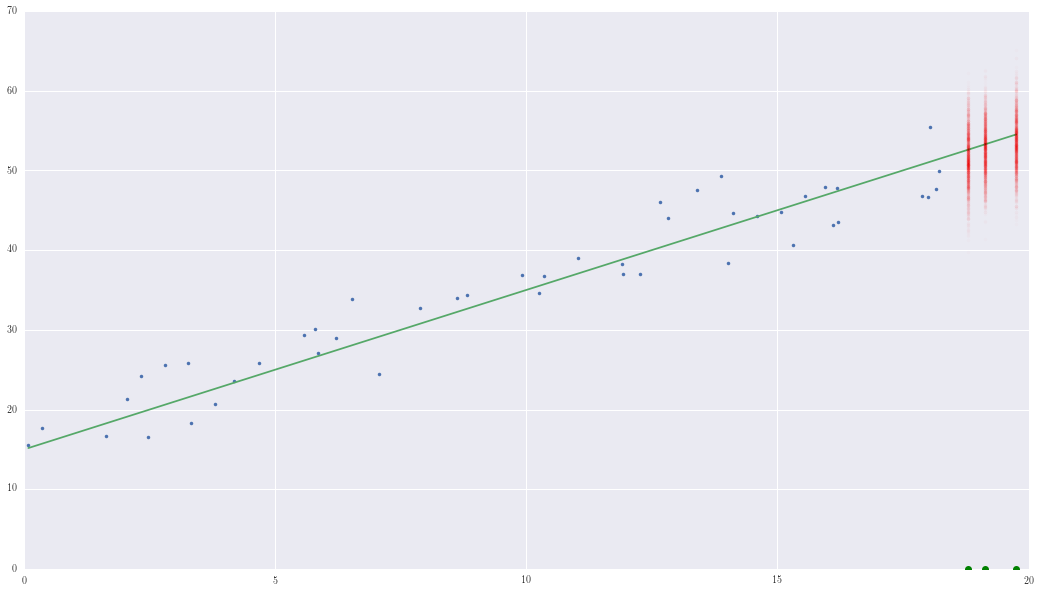

In [20]:
## now we will have three entries in the y_obs trace from this run
y_trace = mcmc.trace('y_obs')[:]

## the original data
plt.plot(x[:-3],y[:-3], '.')
plt.plot(x[-3:],y[-3:], 'go')
plt.plot(x,x*m+c, '-')

# samples from posterior predicted for the missing values of y
plt.plot(np.tile(x[-3], (len(y_trace[:,0]), 1)), y_trace[:,0],  'r.', alpha=0.01)
plt.plot(np.tile(x[-2], (len(y_trace[:,1]), 1)), y_trace[:,1],  'r.', alpha=0.01)
plt.plot(np.tile(x[-1], (len(y_trace[:,2]), 1)), y_trace[:,2],  'r.', alpha=0.01)



Note that, while it makes sense to be able to infer $x$ given $y$, as well as the $y$ given $x$ we just did, PyMC cannot automatically infer variables in this manner. It can only infer the "forward" path in the graph. In theory, if all the determinstic functions (like the line function) were invertible, then this reverse inference could be performed automatically without changing the model.

------------

----------------
# Challenge
<a id="challenge"> </a>

### Task: Build a better model of typing behaviour, and then test if you can predict inter-key times using imputation.

Extend the MCMC model to include key type information (for example, space+enter, punctiuation, numbers, letters). You choose the categories and write code to classify the keystrokes. There is a [list of keycodes here](https://css-tricks.com/snippets/javascript/javascript-keycodes/). **Only choose at most three or four categories of keystroke, or your model will never converge in a reasonable time**.

Build a PyMC model that models the time to the next keystroke, dependent on:

* The previous **keystroke code category** and the current **keystroke code category**
* The previous keystroke press duration and the current keystroke press duration
* The time between the previous keystroke and this one
* The user ID

This model will be something like:

    if you just pressed a whitespace key and then you pressed a directional key, and you are user 202, and you held the last key for 104ms, then the next key will happen in x milliseconds.

Use all of the keystroke data you have. Select the last three elements of the keylog, and try imputing the inter-key time.

Plot a graph showing the predictive posterior against the true values.

## Tips
* Start off with a very simple model, and add variables one at a time. You might start with just a model depending on the user ID, and work from there, or start with the duration of the current keycode only, and work from there.
* You might want to condense the key code categories and the user id into a **single** categorical variable to make the model easier to write down.
* If you find you're not getting a good model, try limiting to a single user to begin with, and then expand to multiple users
* For discrete variables (e.g. keycode category, user_id) use observed Categorical variables
* For the timings, try using a Gamma distribution; you could also use a log-normal distribution, but you will have to implement the log transform yourself (not hard, but may require some online research [i.e. check StackOverflow!])


In [ ]:
# Solution

## the variables in the model should go in the list passed to Model
model = pymc.Model([])

## see the graphical representation of the model
show_dag(model)

## Construct a sampler
mcmc = pymc.MCMC(model)

## Sample from the result; you should try changing the number of iterations
mcmc.sample(iter=100000, burn=2000, thin=5)

## Use the trace methods from pymc to explore the distribution of values

## Plot the predictive distributions
